In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()
import wave
from scipy import signal
from scipy.fftpack import fft, ifft

In [52]:
path = '../exp/data'
dis = [20, 40, 80, 100]
db = [-1, 15, 30, 40]
repeat = list(range(5))

In [53]:
def load_wav(name):
    with wave.open(name, 'rb') as f:
        fs = f.getframerate()
        nframes = f.getnframes()
        str_data = f.readframes(nframes)
        nchannels = f.getnchannels()
        print(len(str_data))
        
    wave_data = np.frombuffer(str_data, dtype=np.int16)
    print(wave_data.shape)
    if nchannels == 2:
        wave_data = wave_data.reshape(2, -1)
        wave_data = wave_data.mean(axis=0)
    return fs, wave_data

def load_all(path, dis, db, repeat):
    for di in dis:
        for d in db:
            for r in repeat:
                name = r'{path}/{dis}cm_{db}db_{repeat}.wav'.format(**{
                    'path': path,
                    'dis': di,
                    'db': d,
                    'repeat': r
                })
                load_wav(name)

364540
(182270,)
[ -388.   -275.5  -294.5   806.5   818.5  1226.   1245.    -59.    -67.5
 -1793.  -1787.  -1717.5 -1690.5   592.    573.   2742.5  2724.   2349.5
  2364.   -149.   -156.5 -2143.  -2159.  -1778.5 -1780.5   122.    121.
  1322.   1331.    870.    883.   -136.   -143.   -118.   -124.    869.
   888.   1068.   1073.   -361.   -384.  -1955.5 -1978.  -1803.5 -1796.
   145.5   193.   1853.   1872.5  1471.   1440.5  -395.   -408.5 -1555.
 -1531.5  -961.5  -944.5   271.5   250.5   591.5   562.5   -46.5   -46.
  -546.   -527.   -295.5  -289.5   187.    175.5   246.5   242.5    16.
    17.   -117.   -124.    -40.    -37.5   122.5   126.5   160.    144.5
    28.5    32.5  -131.5  -101.   -181.   -171.    -96.   -107.5    78.
    65.5   317.    311.5   434.5   422.    162.5   165.   -400.   -386.
  -820.5]


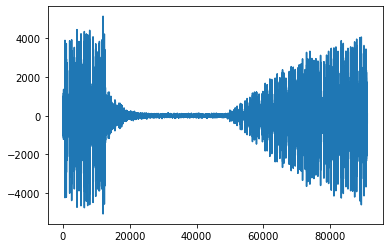

In [300]:
#load_all(path, dis, db, repeat)
fs, data = load_wav('./i.wav')
print(data[1200:1300])
plt.plot(data)

In [301]:
def fda(x, floor, ceil, fs):
    print(fs)
    b, a = signal.butter(8, [2 * floor / fs, 2 * ceil / fs], 'bandpass')
    data = signal.filtfilt(b, a, x)
    print(data.shape)
    return data

48000
(91135,)


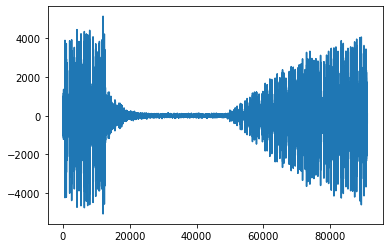

In [302]:
filted = fda(data[:], 17500, 18500, fs)
plt.plot(data)
#plt.plot(filted[:1000])

In [303]:
def dfft(data, f, fs):
    n = data.shape[0]
    window = 100
    impulse_fft = np.zeros((n, 1))
    for i in range(n - window):
        y = fft(data[i:i + window])
        y = np.abs(y)
        index_impulse = round(f / fs * window)
        impulse_fft[i] = np.max(y[index_impulse - 2:index_impulse + 3])
    return impulse_fft

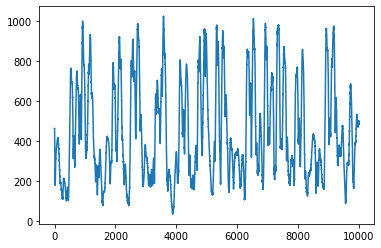

In [304]:
impulse = dfft(filted, 18000, fs)
plt.plot(impulse[:10000])

In [305]:
def smooth(a, window):
    a = a.squeeze()
    out = np.convolve(a, np.ones(window, dtype=int),'valid') / window
    r = np.arange(1, window - 1, 2)
    start = np.cumsum(a[:window - 1])[::2] / r
    stop = (np.cumsum(a[:-window:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

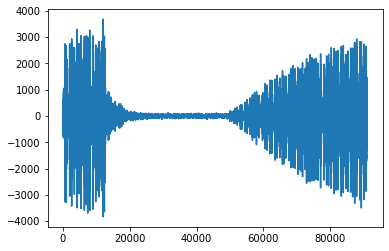

In [306]:
#sm_data = smooth(impulse, 5)
sm_data = smooth(data, 5)
plt.plot(sm_data[:])

In [307]:
def find_max(data, half_window):
    data = data / np.max(data)
    n = data.shape[0]
    position_impulse = []
    for i in range(half_window, n - half_window):
        if data[i] > 0.3 and data[i] == np.max(data[i - half_window:i + half_window + 1]):
            position_impulse.append(i)
    return position_impulse

In [308]:
impulse_pos = find_max(sm_data, 100)
print(impulse_pos)

[613, 1013, 1216, 2013, 2353, 2625, 3424, 4225, 4813, 4825, 5424, 5616, 5880, 6425, 7025, 7413, 8024, 9024, 9824, 9945, 10425, 10824, 11117, 11412, 11624, 12013, 12413, 60560, 61160, 61960, 62560, 63560, 64160, 64960, 65760, 66148, 66760, 67760, 68360, 68960, 69560, 70360, 70748, 71348, 71502, 71749, 72560, 72949, 73360, 73960, 74559, 75160, 75759, 76052, 76348, 77160, 78160, 78302, 78960, 79548, 80360, 81160, 81760, 82359, 82552, 83360, 83960, 84760, 85348, 86160, 86748, 86952, 87359, 87552, 87959, 88252, 88960, 89360, 89552, 90160, 90760]


In [309]:
def demod(pos):
    N = len(pos)
    d = 100
    eps = 45
    message_2 = [0] * ((N - 1) * 2)
    for i in range(N - 1):
        delta = pos[i + 1] - pos[i] - 100
        for mul in range(4):
            if abs(delta - d * (mul + 1)) < eps:
                message_2[i * 2], message_2[i * 2 + 1] = mul >> 1, mul & 1;
                break;
        if delta - d * 4 > eps:
            message_2[i * 2], message_2[i * 2 + 1] = 1, 1
    return message_2

In [310]:
arr = demod(impulse_pos)
print(arr)
print(len(arr))

[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]
160


In [311]:
def decode(arr):
    bin_res = ''.join(map(str, arr))
    res = ''.join([chr(int(bin_res[8*i:8*i+8], 2)) for i in range(len(bin_res) // 8)])
    return res
res = decode(arr)
print(res)

1;ó¯ÿûÿì:ÿ_?üÿò'


In [63]:
real='0101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000'
real

'0101010001110011011010010110111001100111011010000111010101100001001000000101010101101110011010010111011001100101011100100111001101101001011101000111100100100000'

In [119]:
import os

In [125]:
os.listdir('../exp')

['20191117_160148.m4a',
 '20191117_160152.m4a',
 '20191117_160157.m4a',
 '20191117_160202.m4a',
 '20191117_160206.m4a',
 '20191117_160229.m4a',
 '20191117_160247.m4a',
 '20191117_160251.m4a',
 '20191117_160256.m4a',
 '20191117_160300.m4a',
 '20191117_160324.m4a',
 '20191117_160329.m4a',
 '20191117_160333.m4a',
 '20191117_160338.m4a',
 '20191117_160342.m4a',
 '20191117_160440.m4a',
 '20191117_160445.m4a',
 '20191117_160449.m4a',
 '20191117_160518.m4a',
 '20191117_160547.m4a',
 '20191117_160621.m4a',
 '20191117_160625.m4a',
 '20191117_160630.m4a',
 '20191117_160634.m4a',
 '20191117_160639.m4a',
 '20191117_161205.m4a',
 '20191117_161251.m4a',
 '20191117_161256.m4a',
 '20191117_161300.m4a',
 '20191117_161305.m4a',
 '20191117_161330.m4a',
 '20191117_161335.m4a',
 '20191117_161339.m4a',
 '20191117_161343.m4a',
 '20191117_161348.m4a',
 '20191117_161402.m4a',
 '20191117_161407.m4a',
 '20191117_161411.m4a',
 '20191117_161432.m4a',
 '20191117_161436.m4a',
 '20191117_161452.m4a',
 '20191117_16150